# Notebook Title: Attributions on Documents


This notebook demonstrates how SegClarity work to compute, visualize, and interpret attributions for deep learning models trained on document segmentation datasets. It leverages XAI techniques to better understand model predictions at the pixel and region level.

**Purpose**:  
- To apply attribution methods (e.g., Grad-CAM, DeepLift, LRP) to segmentation models trained on document images.
- To visualize and compare attribution maps with original images and ground truth masks.
- To facilitate model interpretability and support error analysis in document segmentation.

**Key Features**:
- Loads pre-trained segmentation models (LUNet, UNet) for different document datasets (UTP, splitAB1).
- Supports multiple attribution methods from Captum and custom utilities.
- Generates and visualizes attribution heatmaps over document images.
- Provides side-by-side comparison of attributions, input images, and segmentation masks.

**Workflow**:
1. Configure dataset and model parameters.
2. Load the appropriate pre-trained segmentation model.
3. Select and apply attribution methods to test images.
4. Visualize attribution maps alongside original images and ground truth.
5. Analyze and interpret the results for model transparency.

**Datasets**:  
- UTP: 7-class document segmentation.
- splitAB1: 4-class document segmentation.

In [1]:
# %%
import os
from sys import path
path.append('..')
from Modules.Dataset import generate_dataset

# %%
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from Modules.Dataset import generate_dataset
from Modules.Architecture import generate_model
from Modules.ModelXAI import generate_XAI_model
from skimage.transform import resize
from Modules.Utils import (
    get_layer_by_name,
    clip_fixed_percentage,
    Normalizations,
    apply_otsu,
)
import Modules.Evaluation as ev

from Modules.Attribution.constants import (
    LUNET_LAYERS_JOURNAL,
    UNET_LAYERS_JOURNAL,
)
from Modules.Attribution import generateAttributions

from Modules.Visualization import (
    visualize_mask,
    visualize_image_and_mask,
    generate_heatmap,
)
from Modules.Visualization.tools import split_components
from Modules.Visualization.core import visualize_image

# %%
dataset_type='splitAB1'
dataset_type='UTP'

base_dir: str = f"../datasets/{dataset_type}"
device = 'cpu'
device = 'cuda:0'

model_type = 'lunet'
MODEL_TAGS = ["from_scratch_models", "finetuned_models_minloss"]
model_tag = MODEL_TAGS[0] if dataset_type == 'UTP' else MODEL_TAGS[1]

OUT_CHANNELS = 7 if dataset_type == 'UTP' else 4

# Dataloader
if dataset_type == 'splitAB1':
    _, _, test_loader = generate_dataset(
        dataset_type=dataset_type,
        base_dir=base_dir,
        **{
            "train_folder": "training-40",
            "validation_folder": "validation",
            "test_folder": "test",
        }
    )
else:
    _, _, test_loader = generate_dataset(
        dataset_type=dataset_type,
        base_dir=base_dir,
        **{
            "train_folder": "Training",
            "validation_folder": "Validation",
            "test_folder": "Test",
        }
    )




UTP_EPOCHS_DICT = {
    "lunet": {MODEL_TAGS[0]: 84, MODEL_TAGS[1]: 61},
    "unet": {MODEL_TAGS[0]: 85, MODEL_TAGS[1]: 43},
}


CB55_EPOCHS_DICT = {
    "lunet": {MODEL_TAGS[0]: 108, MODEL_TAGS[1]: 40},
    "unet": {MODEL_TAGS[0]: 60, MODEL_TAGS[1]: 87},
}



if dataset_type == 'UTP':
    models_path = f"../models/{dataset_type}/{model_type}/{model_tag}"
    model_name = f"model{UTP_EPOCHS_DICT[model_type][model_tag]}.pt"
else:
    models_path = f"../models/{dataset_type}/{model_type}/{model_tag}"
    model_name = f"model{CB55_EPOCHS_DICT[model_type][model_tag]}.pt"

print(f"Loading model from {models_path}")
print(f"Model name: {model_name}")


# %%
print("Loading model...")
model = generate_model(
    model_type= model_type, 
    out_channels=OUT_CHANNELS, 
    load_from_checkpoint=True,
    models_path=models_path, 
    checkpoint_name=model_name
).eval().to(device)

# Prepare model for XAI
model = generate_XAI_model(model=model, device=device)

/home/bonobo/anaconda3/envs/camera/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


the number of image/label in the train:  1
the number of image/label in the validation:  1
the number of image/label in the test:  4
Loading model from ../models/UTP/lunet/from_scratch_models
Model name: model84.pt
Loading model...
../models/UTP/lunet/from_scratch_models/model84.pt
Model loaded successfully


/media/bonobo/flaref/SegClarity/Notebooks/../Modules/Architecture/core.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [2]:
for idx, (image_batch, mask_batch, paths) in tqdm(enumerate(test_loader)):
    image_batch = image_batch.to(device, dtype=torch.float)
    image_name = paths[0][0].split("/")[-1].split(".")[0]
    break
    

0it [00:00, ?it/s]


/media/bonobo/flaref/SegClarity/Notebooks/../Modules/Visualization/core.py:303: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


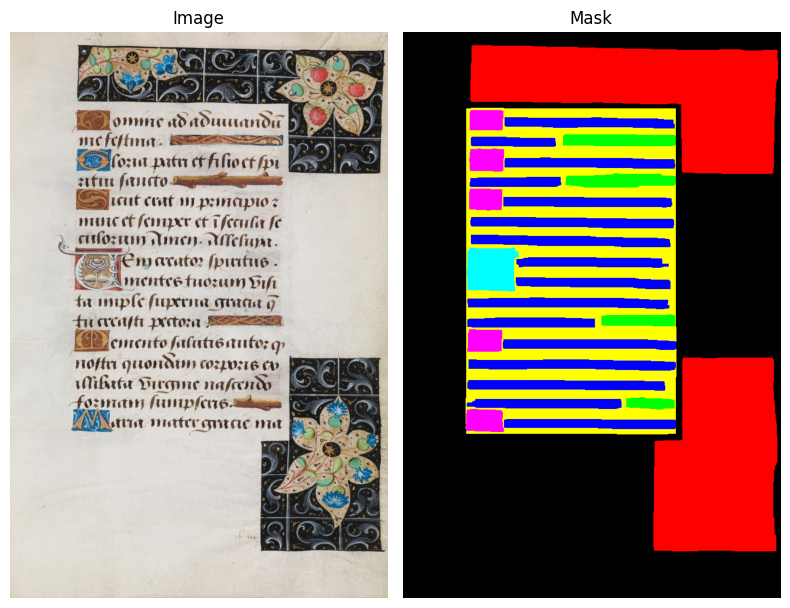

In [3]:
fig,axes = plt.subplots(1,2,figsize=(8,6))
_ = visualize_image_and_mask(image_batch.squeeze().detach().cpu(),mask_batch.detach().cpu(), dataset_type=dataset_type,fig=fig,axes=axes)

### Attribution Computation

In [4]:
# choose method between LayerLRP, LayerDeepLift, LayerGradientXActivation, LayerGradCam
method = "LayerLRP"
selected_target = 1 if dataset_type == "UTP" else 1

layers = LUNET_LAYERS_JOURNAL if model_type == "lunet" else UNET_LAYERS_JOURNAL
layers = list(layers.keys())
layer_name = layers[-2];print(layer_name)

layer_mapper = {
    "conv1.0": "Dec4",
    "conv2.0": "Dec3",
    "conv3.0": "Dec2",
    "conv4.0": "Dec1",    
    "conv5.0": "Dec4",
    "conv6.0": "Dec3",
    "conv7.0": "Dec2",
    "conv8.0": "Dec1",
    "final_layer": "FL",
}

attr = generateAttributions(image_batch, model, selected_target, method, get_layer_by_name(model, layer_name))
attr = clip_fixed_percentage(attr,p=0.05)

if attr.max() > 10e4:
    attr = Normalizations.pick('normalize_log')(attr)

pv,nv,zv = split_components(attr,zero_threshold=0.05)


conv4.0


/home/bonobo/anaconda3/envs/camera/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


### Visualize heatmap

/media/bonobo/flaref/SegClarity/Notebooks/../Modules/Visualization/core.py:242: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


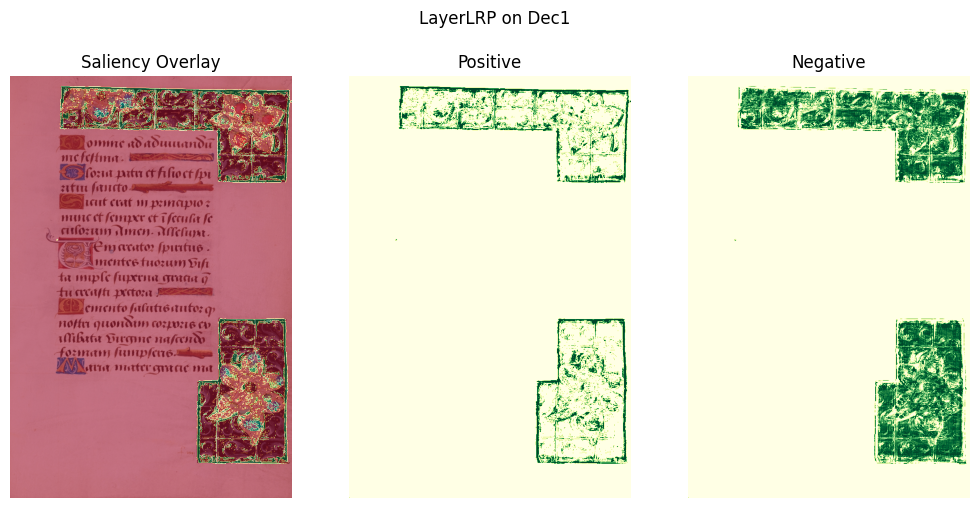

In [5]:
fig,axes = plt.subplots(1,3,figsize=(10,6))
fig.suptitle(f"{method} on {layer_mapper[layer_name]}",y=0.95)


viz_image = image_batch.squeeze().detach().cpu()

viz_image = torch.from_numpy(resize(viz_image, (3,*attr.shape[-2:]), anti_aliasing=True))

if nv.sum() == 0:
    cmap="YlGn"
elif pv.sum() == 0:
    cmap="YlOrRd"
else:
    cmap="RdYlGn"
_ = visualize_image(viz_image,fig=fig,ax=axes[0]);axes[0].set_title("Saliency Overlay")
axes[0].imshow(pv.detach().cpu().squeeze().numpy(), cmap=cmap, alpha=0.5); axes[0].axis("off")
            
_ = generate_heatmap(pv, fig=fig, ax=axes[1],title="Positive")
_ = generate_heatmap(nv, fig=fig, ax=axes[2],title="Negative")

### Evaluation

**PG Score**

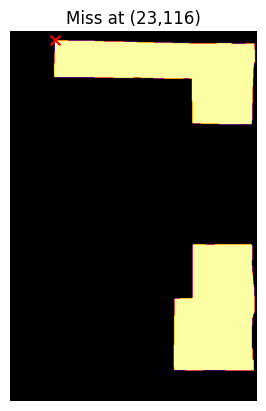

In [6]:
pg_metric = ev.PointingGameMetric()

M = torch.zeros_like(mask_batch)
M[mask_batch == selected_target] = 1
pg_score = pg_metric.calculate(saliency_map=attr,gt_mask=M.squeeze())

import torch
import matplotlib.pyplot as plt

plt.imshow(M[0].detach().cpu().numpy(),cmap='inferno');plt.axis('off')

from captum.attr import LayerAttribution
saliency_map = attr.detach().cpu().clone()
if saliency_map.shape[-2:] != mask_batch.shape[-2:]:
    saliency_map = LayerAttribution.interpolate(
                    saliency_map, mask_batch.squeeze().shape[-2:]
    )

p = torch.argmax(saliency_map).item()
h,w = saliency_map.shape[-2:]
l = p // w
c = p % w

plt.scatter(c,l,color='red',s=50,marker='x')
msg = "Hit" if M[0,l,c] == 1 else "Miss"

_= plt.title(f"{msg} at ({l},{c})")

**CH Score**

In [7]:
ch_metric = ev.ContentHeatmapMetric()

ch_score = ch_metric.calculate(attr=attr,mask=mask_batch,target=selected_target)
print(ch_score)

0.40416276454925537


<Axes: title={'center': 'Score: 0.510 [with Otsu]'}>

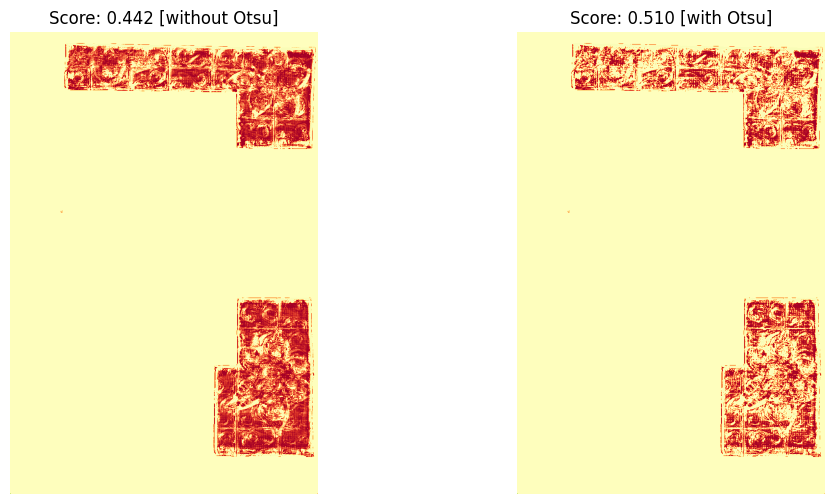

In [8]:
acs_metric = ev.ACSMetric()

metrics, _ = acs_metric.calculate(attr,mask_batch.detach().cpu(), selected_target)
acs = metrics["f1"]
attr_otsu, _ = apply_otsu(attr.detach().cpu())
metrics_otsu, _ = acs_metric.calculate(attr_otsu,mask_batch.detach().cpu(),selected_target)
acs_otsu = metrics_otsu["f1"]

fig,axes = plt.subplots(1,2,figsize=(12,6))
generate_heatmap(attr,fig=fig,ax=axes[0],title=f'Score: {acs:.3f} [without Otsu]')
generate_heatmap(attr_otsu,fig=fig,ax=axes[1],title=f'Score: {acs_otsu:.3f} [with Otsu]')